# Optimisation du calcul de K
## Calculer uniquement la covariance pour les pixels adjacents


### Fonction arrayToVect

Soit N le nombre de pixels enregistré dans un vecteur 1D 
Il faut créer un fonction qui récupère l'index du vecteru 1D en fontion de la ligne et de la colonne : 

$$ f(ligne,colonne) = idx $$

In [3]:
from FeaturesExtractor.misc import *
import numpy as np
import matplotlib.pyplot as plt

#Image aléatoire
l_side = 350
N = l_side*l_side
img = np.random.randn(l_side,l_side)

#Vecteur des coordonnées
Xvec = XVecFromArray(img)

In [4]:
def RBF(a:np.ndarray,b:np.ndarray,l:float,threshold:float):
    xa,ya = a
    xb,yb = b
    d2 = (xa-xb)**2 + (ya-yb)**2
    return np.exp(-d2/(2*l**2))

In [5]:
def arrayToVect(i:int,j:int,l_side:int)->int:
    return i*l_side + j ## Format inversé dans la numérotation

In [6]:
### Test array to vect
Xvec[arrayToVect(25,6,l_side)]

array([25.,  6.])

### Fonction qui récupère la liste des pixels adjacents

On définit $$g(idx) -> ListeAdjacents$$ 

avec ListeAdjacent une liste qui correspond aux idices des pixels adjacents 

<img src="img/adjacent.png" width=200 >


In [7]:
def adjacent(idx:int,l_side:int)->np.ndarray:
    x,y =Xvec[idx]
    dx = np.array([[1,1],[1,0],[1,-1],[0,1],[0,-1],[-1,0],[-1,-1],[-1,1],[0,0]])
    out = Xvec[idx] + dx
    
    indexToDel = []
    for idx in range(9):
        x,y = out[idx]
        #print("out[idx]",out[idx])
        if ( (x<0 or x>=l_side) or (y<0 or y>=l_side)  ):
            indexToDel.append(idx)
    #supprime les index en dehors de l'image
    coord = np.delete(out,indexToDel,axis=0)
    l,c = np.shape(coord)
    out = np.zeros(l)
    for i in range(l):
        out[i]=arrayToVect(coord[i,0],coord[i,1],l_side)
    
    return out.astype(int)



In [8]:
#print(Xvec[30])
print(adjacent(30,l_side))

[381 380 379  31  29  30]


[407 406 405  57  55  56]


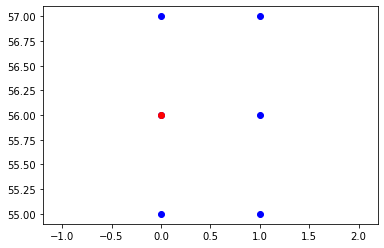

In [9]:
idx=56
idx_list = adjacent(idx,l_side)
print(idx_list)

for adj in idx_list:
    plt.scatter(Xvec[adj][0],Xvec[adj][1],color ='b')
plt.scatter(Xvec[idx][0],Xvec[idx][1],color ='r')
plt.axis("equal")
plt.show()


In [10]:
from scipy import sparse as s
import time

l=3
threshold = 1
l_side = 350
N = l_side*l_side
M = s.lil_matrix((N,N))


start = time.time()
for i in range(N):
    adj = adjacent(i,l_side)
    x = Xvec[i]
    for j in adj:
        y = Xvec[j]
        M[i,j] = RBF(x,y,l,threshold)
dt = time.time() -start

In [11]:
print("dt: ",dt)
print("taille: ",M.data.nbytes)

dt:  16.640928030014038
taille:  980000


In [12]:
slice = M[:500,:500].toarray()

float64


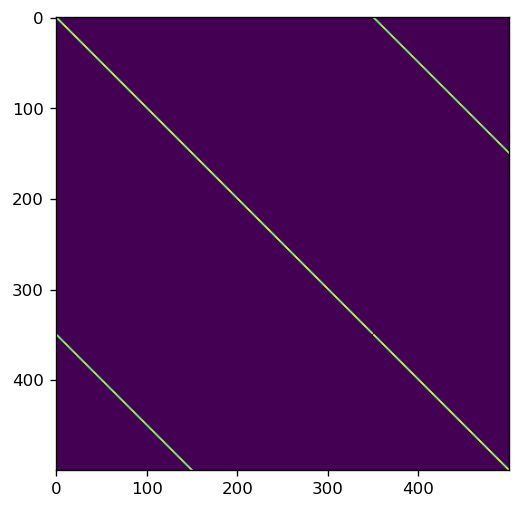

In [13]:
print(slice.dtype)
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120
plt.imshow(slice)

## Essai avec valeurs réelles

$$K_{full} = K^TWK $$

In [ ]:
import ImageProcessing.processing as pr
import numpy as np
import matplotlib.pyplot as plt
import cv2

imgPath = imagePath = "data/19_Droit.jpg"

#Utilisation du paquet
img =pr.cropToCoin(imgPath)
contours = pr.getContour(img)

Xvec = XVecFromArray(contours)

plt.imshow(contours)
plt.show()


In [ ]:
from FeaturesExtractor.misc import *
from FeaturesExtractor import Kernel as k
### Création du noyeau 

shape=np.shape(contours)
l_side,b = shape

N = np.size(contours)

#Vecteur de poids
weightVec = contours.ravel()


In [ ]:
l=3
threshold = 1

K = s.lil_matrix((N,N))


start = time.time()
for i in range(N):
    adj = adjacent(i,l_side)
    x = Xvec[i]
    for j in adj:
        y = Xvec[j]
        K[i,j] = RBF(x,y,l,threshold)
dt = time.time() -start

In [ ]:
print(dt)
slice = K[:370,:370].toarray()


In [ ]:
W = s.diags(weightVec)

In [ ]:
Kw = (K.transpose()).dot(W).dot(K)

In [ ]:
varVect = Kw.diagonal()

In [ ]:
newVarMap = np.reshape(varVect,shape)


ker = k.Kernel(weightVec,Xvec,l,threshold)

varVect = ker.getVarVector()

varMap = np.reshape(varVect,shape)

In [ ]:
plt.subplot(1,2,1)
plt.title("Originale")
plt.imshow(varMap)

plt.subplot(1,2,2)
plt.title("Approximation")
plt.imshow(newVarMap)
plt.show()

## Théorie 

### Complexité cas naif 
On définit la covariance pondérée par 

$$ k_l^\omega(x_i,x_j) = \sum_{k=1}^{N}{k_{l/2}(x_i,x_k) w(x_k) k_{l/2}(x_k,x_j)} $$
ou 
$$ K^\omega_l  = K_{l/2}^T W K_{l/2} $$

Donc pour construire $(K^\omega)_{i,j} = k_l^\omega(x_i,x_j) $ il faut $O(N^3)$ opérations avec $N$ le nombre total de pixels $N=nb_{coté}^2$

### Cas simplifié 

On ne calcule pas toute la matrice K 

Soit $ V(x_{\alpha}) = \{x_i | x_i~voisin~de~x_{\alpha} \} $

Pour une grille de coté $d$ on à un nombre de voinsins de $ (2d+1)^2 $

Le calcul devient 

$$ k_l^\omega(x_i,x_j) = \sum_{x_d \in V(x_i)\cup V(x_j) }^{}{k_{l/2}(x_i,x_k) w(x_k) k_{l/2}(x_k,x_j)} $$

Ainsi on obtient une complexité de $O(Nd^2)$


Comment alors choisir $d$ ? 


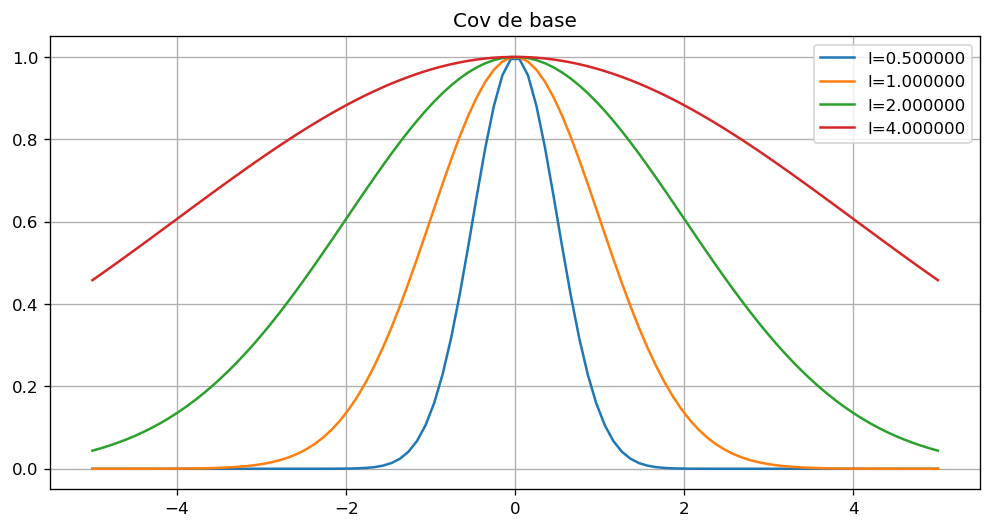

In [2]:
### Kernel en 1D 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120

X = np.linspace(-5,5,100)

l_Liste = [0.5,1,2,4]

for l in l_Liste:
    Y = np.exp(-np.square(X)/(2*l**2))
    plt.plot(X,Y,label="l=%f"%l)
plt.legend()
plt.title("Cov de base")
plt.grid()
plt.show()

## Plus l est grand plus il va avoir d'influence sur le reste des pixels

In [3]:
def newCov(x,l,d):
    if np.abs(x)>d:
        return 0
    return np.exp(-x**2/(2*l**2))

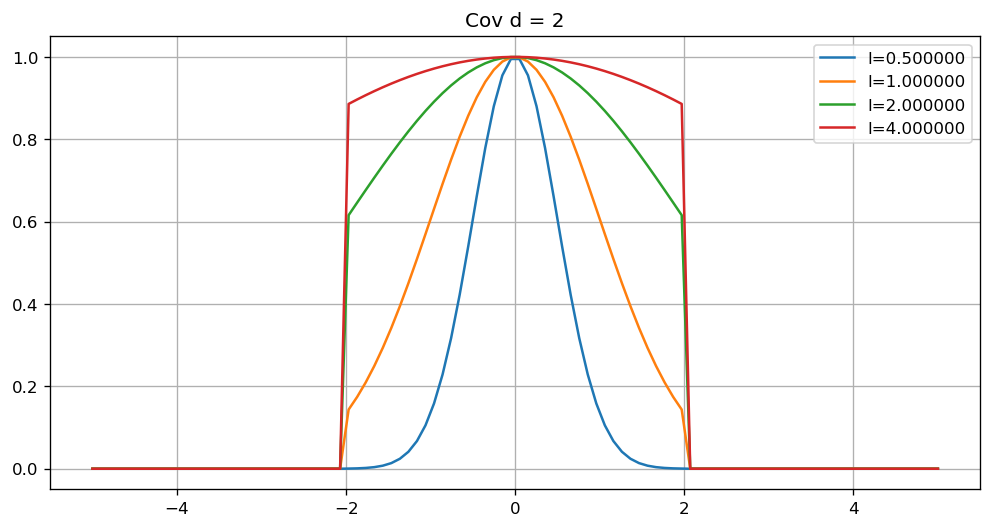

In [4]:

d = 2

l_Liste = [0.5,1,2,4]

for l in l_Liste:
    Y = np.zeros_like(X)
    for idx in range(np.size(X)):
        Y[idx] = newCov(X[idx],l,d)
    plt.plot(X,Y,label="l=%f"%l)
plt.legend()
plt.title("Cov d = %d"%d)
plt.grid()
plt.show()


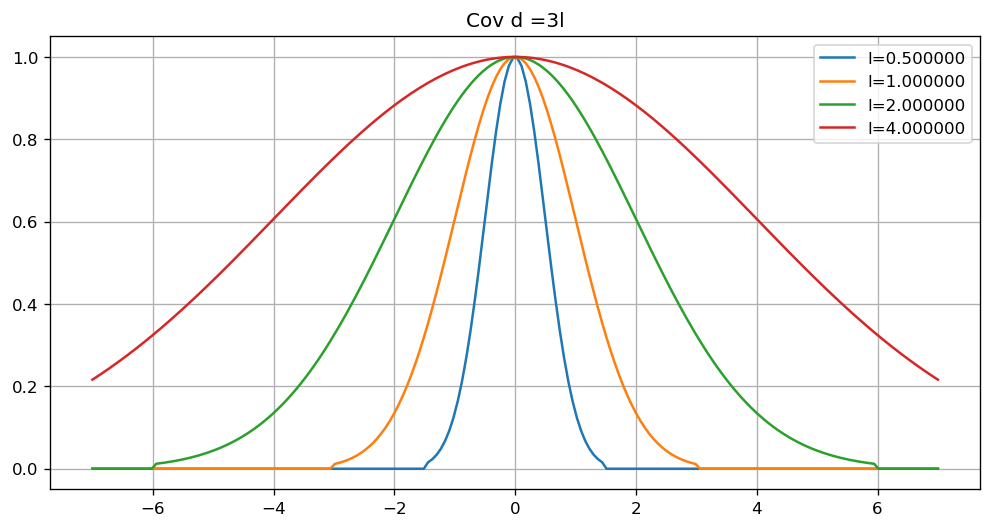

In [5]:
X = np.linspace(-7,7,200)

def covAppr(x,l):
    d = 3*l
    if np.abs(x)>d:
        return 0
    return np.exp(-x**2/(2*l**2))

l_Liste = [0.5,1,2,4]

for l in l_Liste:
    Y = np.zeros_like(X)
    for idx in range(np.size(X)):
        Y[idx] = covAppr(X[idx],l)
    plt.plot(X,Y,label="l=%f"%l)
plt.legend()
plt.title("Cov d =3l")
plt.grid()
plt.show()

 Complexité -> $\rightarrow O(N(2(3l)+1)^2) = O(Nl^2)$
 
 pour $N=360*360$
 
 <img src="img/tempsK.png">